In [119]:
# import important libraries
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from torchvision import transforms
import torchvision.models as models
from torchvision import datasets
import numpy as np

from sklearn.preprocessing import OneHotEncoder

## prepare data

In [120]:
# train transform to add some augmentations to data, normalize it and convert it to tensor.
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random affine transformation
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

# test transform normalize data and convert it to tensor.
test_transform = transforms.Compose([
    transforms.Resize(224),  # Resize the image to 256x256 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet statistics
])

In [121]:
# load train data from folder 
train_data = datasets.ImageFolder("./data/train/",train_transform)

# load test data from folder
test_data = datasets.ImageFolder("./data/test/", test_transform)

In [123]:
# check the shape of train sample
print(train_data[2000][0].shape)

# check the number of train data
print(len(train_data))

torch.Size([3, 224, 224])
2637


In [19]:
# use DataLoader to convert train_data to loader 
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# use DataLoader to convert test_data to loader 
test_loader = DataLoader(test_data, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


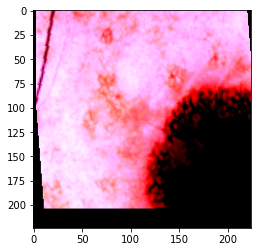

In [124]:
# check image from train_data
plt.imshow(train_data[0][0].permute(1, 2, 0))
print(train_loader.dataset[0][1])

## Model

In [128]:
# use alexnet pretrained model from torchvision for transfer learning
pretrained = models.alexnet(pretrained=True)

# freeze pretrained parameters
for param in pretrained.parameters():
  param.requires_grad = False

# init the numbers of output classes
num_classes = 2

# Create a new linear layer with the appropriate number of outputs
pretrained.classifier[-1] = nn.Linear(pretrained.classifier[-1].in_features, num_classes)


In [129]:
# check if coda is available
torch.cuda.is_available()

True

In [130]:
# if cuda is available device will be cuda otherwise device will be cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [131]:
# loss function, and optimizer
criterion = nn.CrossEntropyLoss()  # Choose an appropriate loss function
optimizer = optim.Adam(pretrained.parameters(), lr=0.001)  # You can choose a different optimizer and learning rate

# Set the device to use GPU if available, otherwise use CPU
pretrained.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [132]:

# Set the number of training epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    pretrained.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = pretrained(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Print the training loss for this epoch
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}")

    # Validation loop
    pretrained.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pretrained(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print the validation accuracy for this epoch
    accuracy = 100 * correct / total
    print(f"Epoch {epoch + 1}, Validation Accuracy: {accuracy}%")

print("Training completed")


Epoch 1, Training Loss: 0.49043803058919455
Epoch 1, Validation Accuracy: 82.42424242424242%
Epoch 2, Training Loss: 0.43039263430095853
Epoch 2, Validation Accuracy: 80.15151515151516%
Epoch 3, Training Loss: 0.4141415435643423
Epoch 3, Validation Accuracy: 81.66666666666667%
Epoch 4, Training Loss: 0.41165793864499955
Epoch 4, Validation Accuracy: 81.06060606060606%
Epoch 5, Training Loss: 0.3899164966174534
Epoch 5, Validation Accuracy: 81.96969696969697%
Epoch 6, Training Loss: 0.39073022206624347
Epoch 6, Validation Accuracy: 82.72727272727273%
Epoch 7, Training Loss: 0.4281630892129171
Epoch 7, Validation Accuracy: 83.78787878787878%
Epoch 8, Training Loss: 0.40856567592847914
Epoch 8, Validation Accuracy: 80.60606060606061%
Epoch 9, Training Loss: 0.4148999871242614
Epoch 9, Validation Accuracy: 83.33333333333333%
Epoch 10, Training Loss: 0.41203108500866664
Epoch 10, Validation Accuracy: 80.15151515151516%
Training completed


In [134]:
# transfer model to cpu
pretrained.to("cpu")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# evaluation

In [135]:
# get the true labels and pred from test_loader
true = []
pred = []
pretrained.eval() # set model to evaluation mode
with torch.no_grad():
  for input, labels in test_loader:
    output = pretrained(input)
    pred.extend(output.tolist())
    true.extend(labels.tolist())


In [136]:
# init OHE encoder
OHE = OneHotEncoder(sparse=False)

In [137]:
# encode true labels using one hot encoder
true = OHE.fit_transform(np.array(true).reshape(-1, 1))

/home/mina/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [138]:
# check true
true

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [143]:
def roc(y_true, y_pred_probs):
    """
    function to calculate tpr, fpr to draw roc curve.

    Args:
        y_true list<int>: true labels.
        y_pred_probs list<int>: pred labels.

    Returns:
        fpr : false positive rate in y_trua and y_pred.
        tpr : true positive rate in y_true and y_pred


    """

    positive_label = 1
    # Ensure y_true and y_pred_probs are numpy arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    # Calculate unique thresholds from predicted probabilities
    thresholds = np.unique(y_pred_probs)


    # Initialize lists to store FPR and TPR values
    fpr = []
    tpr = []

    for threshold in thresholds:
        # Binary classification based on the threshold
        y_pred = (y_pred_probs >= threshold).astype(int)

        # Calculate True Positives, False Positives, True Negatives, and False Negatives
        tp = np.sum((y_true == positive_label) & (y_pred == positive_label))
        fp = np.sum((y_true != positive_label) & (y_pred == positive_label))
        tn = np.sum((y_true != positive_label) & (y_pred != positive_label))
        fn = np.sum((y_true == positive_label) & (y_pred != positive_label))

        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))

    return fpr, tpr

In [157]:
def auc(fpr, tpr):
  """
  function to calculate auc (area under the curve) using trapezoidal rule.

  Args:
      fpr : false positive rate in y_trua and y_pred.
      tpr : true positive rate in y_true and y_pred.
  
  Returns:
      AUC : area under the curve.
  """
  # Initialize variables with sort fpr and tpr.
  fpr_sorted = sorted(fpr)
  tpr_sorted = sorted(tpr)
  sorted_data = [(fpr_sorted[i], tpr_sorted[i]) for i in range(len(tpr_sorted))]
  AUC = 0
  previous_fpr = 0

  # Calculate AUC
  for fpr, tpr in sorted_data:
    delta_fpr = fpr - previous_fpr
    AUC += delta_fpr * tpr
    previous_fpr = fpr
  return AUC

In [154]:
# calculate fpr, tpr from roc function
fpr, tpr = roc(true, pred)

# calculate AUC from auc function
AUC = auc(fpr, tpr)

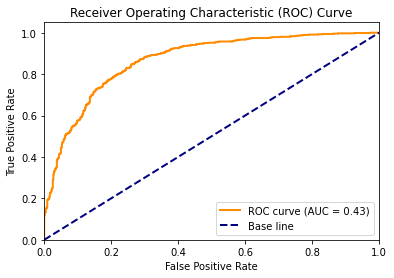

In [155]:
# plot roc curve with auc
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(AUC))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Base line")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()